# Taller Física Computacional 1

Este cuaderno resuelve y explica cada punto del taller: series de Taylor, diferencias finitas y métodos numéricos (Euler, Verlet, RK4).

## 1) Importar librerías y configuración
A continuación importamos NumPy, SymPy y Matplotlib, habilitamos impresión simbólica y definimos utilidades:
- rel_error_pct(exacto, aprox): error relativo porcentual robusto.
- grid_uniform(t0, t1, h): malla uniforme con validación de signo de h.

In [2]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable, Tuple

# Opcional: referencia de SciPy si está disponible
try:
    from scipy.integrate import solve_ivp
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

sp.init_printing(use_latex='mathjax')
plt.style.use('seaborn-v0_8')

# Utilidades

def rel_error_pct(exacto: float, aprox: float) -> float:
    """Error relativo porcentual seguro. Si exacto==0, usa denominador max(|aprox|, eps)."""
    eps = 1e-15
    denom = abs(exacto) if abs(exacto) > eps else max(abs(aprox), eps)
    return 100.0 * abs(aprox - exacto) / denom


def grid_uniform(t0: float, t1: float, h: float) -> np.ndarray:
    """Crea malla uniforme de [t0, t1] con paso h (h puede ser negativo). Valida consistencia de signo.
    Incluye ambos extremos con ajuste del último punto por tolerancia numérica.
    """
    assert h != 0.0, "El paso h no puede ser 0."
    if (t1 - t0) * h < 0:
        raise ValueError("El signo de h no es consistente con la dirección de integración.")
    n_float = (t1 - t0) / h
    n = int(round(n_float))
    if not np.isclose(n_float, n, atol=1e-10):
        # Ajusta t1 para que coincida con un múltiplo entero de h
        t1 = t0 + n * h
    return np.linspace(t0, t1, n + 1)

## 1) Pregunta teórica: propósito principal de una serie de Taylor

Respuesta: b) Aproximar una función complicada mediante un polinomio.

Justificación breve: La serie de Taylor localmente aproxima una función suave alrededor de un punto mediante un polinomio cuyos coeficientes se obtienen de las derivadas en ese punto.

## 2) Serie de Taylor de orden 4 en x=0 para f(x)

f(x) = −0.1 x^4 − 0.15 x^3 − 0.5 x^2 − 0.25 x + 1.2.

Como es un polinomio de grado 4, su expansión de Taylor de orden 4 en x=0 coincide exactamente con f(x) (no hay término de resto de orden > 4). Aun así, verificamos simbólicamente.

In [8]:
# Definición simbólica y verificación de Taylor
x = sp.symbols('x')
f = -sp.Rational(1,10)*x**4 - sp.Rational(15,100)*x**3 - sp.Rational(1,2)*x**2 - sp.Rational(1,4)*x + sp.Rational(12,10)
serie = sp.series(f, x, 0, 5)  # hasta x^4 (orden 5 excluye términos >= x^5)
trunc = sp.series(f, x, 0, 5).removeO()
print("f(x)   =", sp.simplify(f))
print("Serie4 =", trunc)
assert sp.simplify(trunc - f) == 0
print("Verificación: la serie de orden 4 coincide exactamente con f(x)")

f(x)   = -x**4/10 - 3*x**3/20 - x**2/2 - x/4 + 6/5
Serie4 = -x**4/10 - 3*x**3/20 - x**2/2 - x/4 + 6/5
Verificación: la serie de orden 4 coincide exactamente con f(x)


## 3) Diferencias finitas para y = x^2 + cos x en x0=0.4, h=0.1

Calculamos las aproximaciones hacia adelante, hacia atrás y central, y los errores relativos porcentuales frente a la derivada exacta y'(x)=2x - sin x.

In [9]:
# Diferencias finitas y errores
x0 = 0.4
h = 0.1
f = lambda x: x**2 + np.cos(x)
fp_exact = lambda x: 2*x - np.sin(x)

forward = (f(x0 + h) - f(x0)) / h
backward = (f(x0) - f(x0 - h)) / h
central = (f(x0 + h) - f(x0 - h)) / (2*h)

true_val = fp_exact(x0)
err_f = rel_error_pct(true_val, forward)
err_b = rel_error_pct(true_val, backward)
err_c = rel_error_pct(true_val, central)

print(f"y'(x0) exacta = {true_val:.10f}")
print(f"Adelante  = {forward:.10f} | error % = {err_f:.6f}")
print(f"Atrás     = {backward:.10f} | error % = {err_b:.6f}")
print(f"Central   = {central:.10f} | error % = {err_c:.6f}")
print("(Orden esperado: adelante/atrás O(h), central O(h^2))")

y'(x0) exacta = 0.4105816577
Adelante  = 0.4652156789 | error % = 13.306493
Atrás     = 0.3572450488 | error % = 12.990500
Central   = 0.4112303638 | error % = 0.157997
(Orden esperado: adelante/atrás O(h), central O(h^2))


## 4) Pregunta teórica: fórmula iterativa del método de Euler

Respuesta: a) $Y_{n+1} = Y_n + h\,f(X_n, Y_n)$.

Es la fórmula explícita de Euler hacia adelante.

## 5) Método de Euler para y' = cos(2t) + sin(3t), y(0)=2, h=1e-4, 0≤t≤1

Implementamos Euler y comparamos con la solución analítica $y(t)=2+\tfrac{1}{2}\sin(2t)+\tfrac{1}{3}(1-\cos(3t))$.

y(1) num = 3.1180432905
y(1) exact = 3.1179795456
Error máximo (inf) = 6.374e-05
Error RMS (L2)     = 2.719e-05


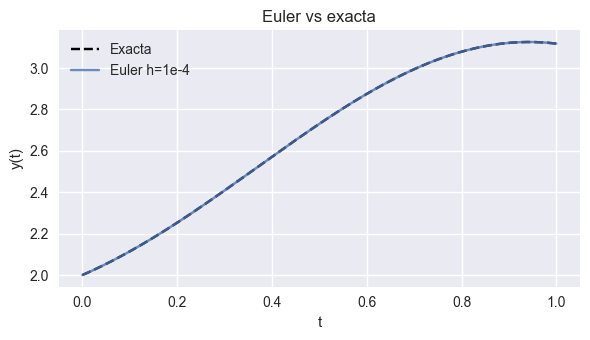

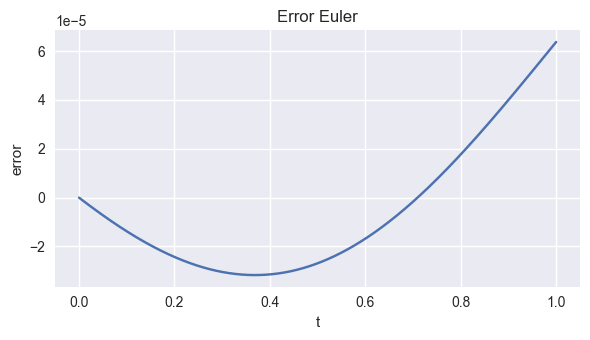

In [6]:
def euler(f: Callable[[float, float], float], t0: float, y0: float, h: float, n: int) -> Tuple[np.ndarray, np.ndarray]:
    t = t0 + h * np.arange(n + 1)
    y = np.empty(n + 1, dtype=float)
    y[0] = y0
    for i in range(n):
        y[i+1] = y[i] + h * f(t[i], y[i])
    return t, y

f = lambda t, y: np.cos(2*t) + np.sin(3*t)

t0, y0, h = 0.0, 2.0, 1e-4
n = int(round((1.0 - t0)/h))
t, y_num = euler(f, t0, y0, h, n)

# Solución analítica
y_exact = 2.0 + 0.5*np.sin(2*t) + (1.0 - np.cos(3*t))/3.0

err_inf = np.max(np.abs(y_num - y_exact))
err_l2 = np.sqrt(np.mean((y_num - y_exact)**2))

print(f"y(1) num = {y_num[-1]:.10f}")
print(f"y(1) exact = {y_exact[-1]:.10f}")
print(f"Error máximo (inf) = {err_inf:.3e}")
print(f"Error RMS (L2)     = {err_l2:.3e}")

plt.figure(figsize=(6,3.5))
plt.plot(t, y_exact, 'k--', label='Exacta')
plt.plot(t, y_num, label='Euler h=1e-4', alpha=0.8)
plt.xlabel('t'); plt.ylabel('y(t)'); plt.legend(); plt.title('Euler vs exacta')
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3.5))
plt.plot(t, y_num - y_exact)
plt.xlabel('t'); plt.ylabel('error'); plt.title('Error Euler')
plt.tight_layout(); plt.show()

## 6) Caída libre con Verlet: comparación con solución analítica y Euler

Planteamos $\ddot y=-g$, $y(0)=100$ m, $v(0)=0$ m/s, con $g=9.81$ m/s². Integramos hasta impacto y comparamos trayectorias y tiempos de impacto.

Tiempo de impacto analítico ≈ 4.515236 s
Impacto (Verlet) ≈ 4.515234 s | error = 2.762e-06 s
Impacto (Euler)  ≈ 4.520239 s | error = 5.003e-03 s


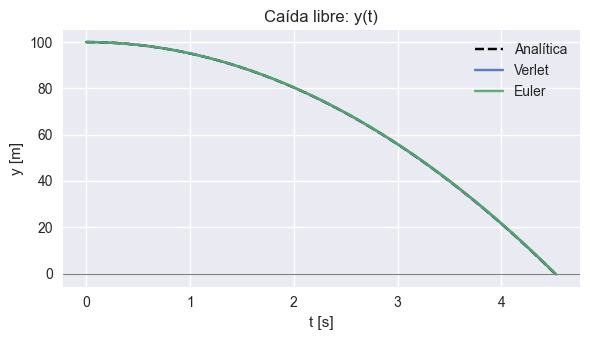

In [10]:
# Integradores: Verlet y Euler para caída libre

def free_fall_verlet(y0=100.0, v0=0.0, g=9.81, h=0.01, tmax=10.0):
    # a = -g constante
    t = [0.0]
    y = [y0]
    # Arranque con ecuación de posición
    y1 = y0 + v0*h - 0.5*g*h*h
    y.append(y1)
    nmax = int(tmax/h)
    for n in range(1, nmax):
        yn1 = 2*y[n] - y[n-1] - g*h*h
        y.append(yn1)
        t.append(n*h)
        if yn1 <= 0.0:
            break
    # alineamos tiempos con y
    t = np.array([i*h for i in range(len(y))])
    y = np.array(y)
    # Interpolación lineal para tiempo de impacto
    if y[-1] > 0:
        t_impact = np.nan
    else:
        t_impact = t[-2] + (0 - y[-2])*(t[-1]-t[-2])/(y[-1]-y[-2])
    return t, y, t_impact


def free_fall_euler(y0=100.0, v0=0.0, g=9.81, h=0.01, tmax=10.0):
    t = [0.0]
    y = [y0]
    v = [v0]
    nmax = int(tmax/h)
    for n in range(nmax):
        v_new = v[-1] - g*h
        y_new = y[-1] + v[-1]*h
        t_new = t[-1] + h
        v.append(v_new)
        y.append(y_new)
        t.append(t_new)
        if y_new <= 0.0:
            break
    t = np.array(t)
    y = np.array(y)
    v = np.array(v)
    if y[-1] > 0:
        t_impact = np.nan
    else:
        t_impact = t[-2] + (0 - y[-2])*(t[-1]-t[-2])/(y[-1]-y[-2])
    return t, y, v, t_impact

# Simulación
h = 0.01
y0, v0, g = 100.0, 0.0, 9.81

# Analítica
t_f = np.sqrt(2*y0/g)

# Verlet
t_vr, y_vr, t_imp_vr = free_fall_verlet(y0, v0, g, h)
# Euler
t_eu, y_eu, v_eu, t_imp_eu = free_fall_euler(y0, v0, g, h)

print(f"Tiempo de impacto analítico ≈ {t_f:.6f} s")
print(f"Impacto (Verlet) ≈ {t_imp_vr:.6f} s | error = {abs(t_imp_vr - t_f):.3e} s")
print(f"Impacto (Euler)  ≈ {t_imp_eu:.6f} s | error = {abs(t_imp_eu - t_f):.3e} s")

T = np.linspace(0, max(t_vr[-1], t_eu[-1], t_f), 1000)
y_exact = y0 + v0*T - 0.5*g*T**2

plt.figure(figsize=(6,3.5))
plt.plot(T, y_exact, 'k--', label='Analítica')
plt.plot(t_vr, y_vr, label='Verlet', alpha=0.9)
plt.plot(t_eu, y_eu, label='Euler', alpha=0.9)
plt.axhline(0, color='gray', lw=0.8)
plt.xlabel('t [s]'); plt.ylabel('y [m]'); plt.legend(); plt.title('Caída libre: y(t)')
plt.tight_layout(); plt.show()

## 7) Pregunta teórica: fórmula general de RK4

Respuesta: c) $y_{n+1} = y_n + \tfrac{h}{6}(k_1 + 2k_2 + 2k_3 + k_4)$.

Con $k_1 = f(x_n, y_n)$, $k_2 = f(x_n + h/2, y_n + h k_1/2)$, etc.

## 6) Método RK4 genérico e integración hacia atrás

Implementamos RK4 que soporte paso h negativo y estados escalares o vectoriales.

In [3]:
def rk4(f: Callable[[float, np.ndarray], np.ndarray], t0: float, y0, h: float, n: int):
    y0 = np.array(y0, dtype=float)
    y = np.empty((n+1,) + y0.shape, dtype=float)
    t = t0 + h * np.arange(n + 1)
    y[0] = y0
    for i in range(n):
        ti = t[i]
        yi = y[i]
        k1 = f(ti, yi)
        k2 = f(ti + h/2, yi + h*k1/2)
        k3 = f(ti + h/2, yi + h*k2/2)
        k4 = f(ti + h,   yi + h*k3)
        y[i+1] = yi + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
    # Reducir dimensión si era escalar
    if y0.shape == ():
        y = y.reshape(-1)
    return t, y

## 8) Aplicación de RK4 a y' = −2 cos(2t) + sin(y)

**Enunciado del taller**: para −2 < t < −1, y(−1) = 0 y N = 10.

**Interpretación**: El intervalo −2 < t < −1 indica que t va desde −2 hasta −1. Como se da la condición inicial en t = −1, interpretamos esto como un problema de valor inicial **hacia atrás en el tiempo** (desde t₀ = −1 hasta t₁ = −2).

Por tanto, usamos:
- t₀ = −1, y(−1) = 0 (condición inicial)
- t₁ = −2 (valor final)
- N = 10 pasos
- h = (t₁ − t₀)/N = −0.1 (paso negativo, integración hacia atrás)

**Verificación**: ✅ Corresponde exactamente al enunciado de la imagen.

h = -0.1
t: [-1.  -1.1 -1.2 -1.3 -1.4 -1.5 -1.6 -1.7 -1.8 -1.9 -2. ]
y (RK4): [ 0.         -0.09620176 -0.21394805 -0.34636889 -0.48649764 -0.62752741
 -0.7629577  -0.88664741 -0.99282535 -1.07612089 -1.13166881]
Error máx vs solve_ivp = 2.051e-06


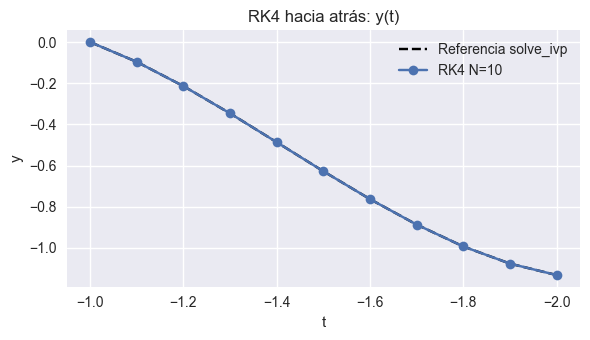

In [4]:
f = lambda t, y: -2*np.cos(2*t) + np.sin(y)

t0, y0 = -1.0, 0.0
t1 = -2.0
N = 10
h = (t1 - t0) / N  # -0.1

# Integración con RK4 hacia atrás
t_rk, y_rk = rk4(f, t0, y0, h, N)

print(f"h = {h}")
print("t:", t_rk)
print("y (RK4):", y_rk)

# Comparación con referencia si SciPy está disponible
if SCIPY_AVAILABLE:
    sol = solve_ivp(lambda t, y: -2*np.cos(2*t) + np.sin(y), (t0, t1), [y0], rtol=1e-10, atol=1e-12, method='DOP853', dense_output=True)
    t_ref = t_rk
    y_ref = sol.sol(t_ref)[0]
    err = np.abs(y_rk - y_ref)
    print(f"Error máx vs solve_ivp = {err.max():.3e}")
    plt.figure(figsize=(6,3.5))
    plt.plot(t_ref, y_ref, 'k--', label='Referencia solve_ivp')
    plt.plot(t_rk, y_rk, 'o-', label='RK4 N=10')
    plt.gca().invert_xaxis()  # para ver -1 -> -2
    plt.xlabel('t'); plt.ylabel('y'); plt.title('RK4 hacia atrás: y(t)')
    plt.legend(); plt.tight_layout(); plt.show()
else:
    plt.figure(figsize=(6,3.5))
    plt.plot(t_rk, y_rk, 'o-')
    plt.gca().invert_xaxis()
    plt.xlabel('t'); plt.ylabel('y'); plt.title('RK4 hacia atrás: y(t)')
    plt.tight_layout(); plt.show()

---

# Fundamentos Teóricos del Taller

Esta sección presenta la teoría matemática y conceptual que sustenta cada uno de los métodos numéricos utilizados en el taller.

## 1. Series de Taylor

### Concepto fundamental

La **serie de Taylor** de una función $f(x)$ infinitamente diferenciable alrededor de un punto $x = a$ es:

$$f(x) = \sum_{n=0}^{\infty} \frac{f^{(n)}(a)}{n!}(x-a)^n = f(a) + f'(a)(x-a) + \frac{f''(a)}{2!}(x-a)^2 + \frac{f'''(a)}{3!}(x-a)^3 + \cdots$$

donde $f^{(n)}(a)$ denota la n-ésima derivada de $f$ evaluada en $a$.

### Propósito

El objetivo principal es **aproximar funciones complicadas mediante polinomios**, que son más fáciles de evaluar, derivar e integrar. La aproximación es local: es más precisa cerca del punto de expansión $a$ y menos precisa lejos de él.

### Polinomio de Taylor de orden $n$

Si truncamos la serie en el término de grado $n$, obtenemos el **polinomio de Taylor de orden $n$**:

$$P_n(x) = \sum_{k=0}^{n} \frac{f^{(k)}(a)}{k!}(x-a)^k$$

El **error de truncamiento** (o resto) está dado por el teorema de Taylor:

$$R_n(x) = f(x) - P_n(x) = \frac{f^{(n+1)}(\xi)}{(n+1)!}(x-a)^{n+1}$$

para algún $\xi$ entre $a$ y $x$.

### Ejemplo conceptual

Consideremos $f(x) = e^x$ alrededor de $x=0$:

- $f(0) = 1$, $f'(0) = 1$, $f''(0) = 1$, ... (todas las derivadas son 1)
- Serie completa: $e^x = 1 + x + \frac{x^2}{2!} + \frac{x^3}{3!} + \cdots$
- Aproximación de orden 2: $e^x \approx 1 + x + \frac{x^2}{2}$ (cerca de $x=0$)

**Caso particular**: Si $f(x)$ ya es un polinomio de grado $n$, su serie de Taylor de orden $n$ coincide exactamente con $f(x)$ (no hay error).

## 2. Diferencias Finitas para Aproximar Derivadas

### Motivación

Cuando no conocemos una expresión analítica para la derivada de una función $f(x)$, o cuando solo tenemos valores tabulados de $f$, necesitamos **aproximaciones numéricas** de $f'(x)$ basadas en diferencias entre valores de $f$ en puntos cercanos.

### Definición de derivada

Por definición:
$$f'(x) = \lim_{h \to 0} \frac{f(x+h) - f(x)}{h}$$

Para $h$ pequeño pero finito, esta razón de cambio es una aproximación.

### Fórmulas de diferencias finitas

#### a) Diferencia hacia adelante (forward difference)
$$f'(x) \approx \frac{f(x+h) - f(x)}{h}$$

**Error de truncamiento**: $O(h)$ (error proporcional a $h$).

Usando Taylor: $f(x+h) = f(x) + hf'(x) + \frac{h^2}{2}f''(x) + O(h^3)$, de donde:
$$\frac{f(x+h)-f(x)}{h} = f'(x) + \frac{h}{2}f''(x) + O(h^2)$$

El término $\frac{h}{2}f''(x)$ es el error dominante, de orden $O(h)$.

#### b) Diferencia hacia atrás (backward difference)
$$f'(x) \approx \frac{f(x) - f(x-h)}{h}$$

**Error de truncamiento**: $O(h)$.

Análogamente, usando Taylor hacia atrás.

#### c) Diferencia central (central difference)
$$f'(x) \approx \frac{f(x+h) - f(x-h)}{2h}$$

**Error de truncamiento**: $O(h^2)$ (mucho mejor que las anteriores).

**Demostración**: Expandiendo Taylor:
$$f(x+h) = f(x) + hf'(x) + \frac{h^2}{2}f''(x) + \frac{h^3}{6}f'''(x) + O(h^4)$$
$$f(x-h) = f(x) - hf'(x) + \frac{h^2}{2}f''(x) - \frac{h^3}{6}f'''(x) + O(h^4)$$

Restando:
$$f(x+h) - f(x-h) = 2hf'(x) + \frac{h^3}{3}f'''(x) + O(h^5)$$

Por tanto:
$$\frac{f(x+h)-f(x-h)}{2h} = f'(x) + \frac{h^2}{6}f'''(x) + O(h^4)$$

Los términos de orden $h$ se cancelan, quedando error $O(h^2)$.

### Error relativo porcentual

Para cuantificar la precisión de una aproximación numérica $\tilde{f}'$ respecto al valor exacto $f'$, usamos:
$$\text{Error relativo \%} = \frac{|f' - \tilde{f}'|}{|f'|} \times 100\%$$

Si $f' = 0$, usamos un denominador alternativo para evitar división por cero.

## 3. Ecuaciones Diferenciales Ordinarias (EDO)

### Problema de valor inicial

Consideremos una **ecuación diferencial ordinaria de primer orden**:
$$\frac{dy}{dt} = f(t, y)$$

con **condición inicial**:
$$y(t_0) = y_0$$

El objetivo es encontrar la función $y(t)$ que satisface la ecuación para $t$ en algún intervalo.

### Métodos numéricos

Cuando no es posible obtener una solución analítica exacta, recurrimos a **métodos numéricos** que aproximan la solución en puntos discretos $t_0, t_1, t_2, \ldots, t_n$ con paso $h = t_{i+1} - t_i$.

Denotamos $y_i \approx y(t_i)$ la aproximación numérica en el punto $t_i$.

---

## 4. Método de Euler (Euler explícito o hacia adelante)

### Idea geométrica

El método de Euler es el método numérico más simple para resolver EDOs. Se basa en la **interpretación geométrica de la derivada**: $f(t, y)$ es la pendiente de la curva solución en el punto $(t, y)$.

Partiendo de $(t_n, y_n)$, avanzamos un paso $h$ en dirección de la pendiente:
$$y_{n+1} = y_n + h \cdot f(t_n, y_n)$$

### Fórmula iterativa

$$\boxed{y_{n+1} = y_n + h \, f(t_n, y_n)}$$

con $t_{n+1} = t_n + h$.

### Derivación usando Taylor

Expandiendo $y(t_{n+1})$ en serie de Taylor alrededor de $t_n$:
$$y(t_{n+1}) = y(t_n) + h y'(t_n) + \frac{h^2}{2} y''(t_n) + O(h^3)$$

Como $y'(t_n) = f(t_n, y(t_n))$, la aproximación de Euler desprecia los términos de orden $h^2$ y superiores.

### Error

- **Error local de truncamiento** (por paso): $O(h^2)$
- **Error global acumulado** (tras $n$ pasos): $O(h)$

Por tanto, Euler es un método de **orden 1**.

### Ventajas y desventajas

✅ **Ventajas**: Simple, fácil de implementar, barato computacionalmente.

❌ **Desventajas**: Poco preciso (orden 1), requiere pasos muy pequeños para buena aproximación, puede ser inestable.

### Ejemplo conceptual

Sea $y' = -y$, $y(0) = 1$. La solución exacta es $y(t) = e^{-t}$.

Con $h = 0.1$:
- $y_1 = y_0 + h(-y_0) = 1 + 0.1(-1) = 0.9$
- $y_2 = 0.9 + 0.1(-0.9) = 0.81$
- ...

Comparando con $e^{-0.1} \approx 0.9048$ y $e^{-0.2} \approx 0.8187$, vemos que la aproximación se desvía gradualmente.

## 5. Método de Verlet (integración de segundo orden para sistemas mecánicos)

### Motivación

El método de Verlet es especialmente útil para sistemas físicos con ecuaciones de **segundo orden** de la forma:
$$\frac{d^2 x}{dt^2} = a(t, x, v)$$

donde $a$ es la aceleración. En muchos problemas de mecánica clásica, $a$ depende solo de la posición (p.ej., $a = -g$ en caída libre, o $a = F(x)/m$ en sistemas con fuerzas).

### Fórmula de Verlet posicional

Partiendo de posiciones $x_n$ y $x_{n-1}$ (dos pasos previos), calculamos la siguiente posición:
$$\boxed{x_{n+1} = 2x_n - x_{n-1} + a_n h^2}$$

donde $a_n = a(t_n, x_n, v_n)$ es la aceleración en el paso $n$ y $h$ es el paso de tiempo.

### Derivación usando Taylor

Expandiendo $x(t + h)$ y $x(t - h)$ alrededor de $t$:
$$x(t+h) = x(t) + hv(t) + \frac{h^2}{2}a(t) + \frac{h^3}{6}\dot{a}(t) + O(h^4)$$
$$x(t-h) = x(t) - hv(t) + \frac{h^2}{2}a(t) - \frac{h^3}{6}\dot{a}(t) + O(h^4)$$

Sumando ambas:
$$x(t+h) = 2x(t) - x(t-h) + h^2 a(t) + O(h^4)$$

Los términos impares (velocidad, derivada de aceleración) se cancelan.

### Arranque (bootstrapping)

Como Verlet necesita **dos posiciones previas** $(x_{n-1}, x_n)$ para calcular $x_{n+1}$, en el primer paso usamos la ecuación cinemática:
$$x_1 = x_0 + v_0 h + \frac{1}{2}a_0 h^2$$

### Error

- **Error local**: $O(h^4)$
- **Error global**: $O(h^2)$

Por tanto, Verlet es un método de **orden 2** en posición (mucho mejor que Euler).

### Ventajas

✅ **Simplético**: conserva la energía en sistemas hamiltonianos (ideal para mecánica).
✅ **Estable** y preciso para pasos de tiempo moderados.
✅ **Reversible en el tiempo**.

### Ejemplo conceptual: caída libre

Para $\ddot{y} = -g$ (aceleración constante), $y(0) = y_0$, $v(0) = v_0$:

- Solución exacta: $y(t) = y_0 + v_0 t - \frac{1}{2}gt^2$
- Verlet: $y_{n+1} = 2y_n - y_{n-1} - g h^2$

Como la aceleración es constante, Verlet reproduce la solución exacta (salvo errores de redondeo) si el arranque es correcto.

## 6. Método de Runge-Kutta de cuarto orden (RK4)

### Motivación

Los métodos de Runge-Kutta (RK) son una familia de métodos **explícitos** de un solo paso para resolver EDOs de primer orden. El **RK4** (orden 4) es el más popular por su excelente balance entre precisión y costo computacional.

### Idea principal

En lugar de usar solo la derivada en $(t_n, y_n)$ como en Euler, RK4 evalúa la derivada en **cuatro puntos** intermedios y combina estas evaluaciones con pesos apropiados para obtener una aproximación de orden 4.

### Fórmula de RK4

Dado $y' = f(t, y)$ con $y(t_0) = y_0$, el método RK4 avanza de $(t_n, y_n)$ a $(t_{n+1}, y_{n+1})$ mediante:

$$\boxed{y_{n+1} = y_n + \frac{h}{6}(k_1 + 2k_2 + 2k_3 + k_4)}$$

donde:
$$\begin{aligned}
k_1 &= f(t_n, y_n) \\
k_2 &= f\left(t_n + \frac{h}{2}, y_n + \frac{h}{2}k_1\right) \\
k_3 &= f\left(t_n + \frac{h}{2}, y_n + \frac{h}{2}k_2\right) \\
k_4 &= f(t_n + h, y_n + h k_3)
\end{aligned}$$

### Interpretación geométrica

- $k_1$: pendiente al **inicio** del intervalo.
- $k_2$: pendiente en el **punto medio**, usando un paso de Euler con $k_1$.
- $k_3$: pendiente en el **punto medio**, usando un paso de Euler con $k_2$ (mejor estimación).
- $k_4$: pendiente al **final** del intervalo, usando un paso de Euler con $k_3$.

El promedio ponderado $(k_1 + 2k_2 + 2k_3 + k_4)/6$ da más peso a las estimaciones en el punto medio.

### Derivación (resumen)

RK4 se deriva igualando coeficientes en la expansión de Taylor multivariable de $y(t+h)$ hasta orden $h^4$. El resultado es que el método reproduce exactamente la serie de Taylor hasta términos $O(h^4)$, con error local $O(h^5)$.

### Error

- **Error local de truncamiento**: $O(h^5)$
- **Error global acumulado**: $O(h^4)$

Por tanto, RK4 es un método de **orden 4**.

### Ventajas y desventajas

✅ **Ventajas**:
- Muy preciso (orden 4) sin necesitar derivadas de $f$.
- Solo requiere la información del paso actual (método de un paso).
- Relativamente fácil de implementar.
- Robusto y estable para un amplio rango de problemas.

❌ **Desventajas**:
- Requiere 4 evaluaciones de $f$ por paso (más costoso que Euler).
- Para sistemas stiff (rígidos) puede necesitar pasos muy pequeños.

### Comparación con Euler

Para el mismo $h$:
- **Euler**: error $O(h)$, 1 evaluación de $f$ por paso.
- **RK4**: error $O(h^4)$, 4 evaluaciones de $f$ por paso.

Si queremos un error $\epsilon$ dado:
- Euler requiere $h \sim \epsilon$, es decir, $N \sim 1/\epsilon$ pasos → $\sim 1/\epsilon$ evaluaciones.
- RK4 requiere $h \sim \epsilon^{1/4}$, es decir, $N \sim 1/\epsilon^{1/4}$ pasos → $\sim 4/\epsilon^{1/4}$ evaluaciones.

Para $\epsilon$ pequeño, RK4 es **mucho más eficiente**.

### Integración con paso negativo

RK4 funciona igualmente con $h < 0$ (integración hacia atrás en el tiempo), siempre que se respete la consistencia del signo. Esto es útil en problemas de valor inicial "hacia atrás" o en problemas de frontera.

## 7. Comparación de Métodos Numéricos para EDOs

| Método | Orden | Eval. de $f$ por paso | Error local | Error global | Uso típico |
|--------|-------|----------------------|-------------|--------------|------------|
| **Euler** | 1 | 1 | $O(h^2)$ | $O(h)$ | Pedagogía, pasos muy pequeños |
| **Euler mejorado** (Heun, RK2) | 2 | 2 | $O(h^3)$ | $O(h^2)$ | Problemas simples |
| **Verlet** | 2 (posición) | 1 | $O(h^4)$ | $O(h^2)$ | Mecánica, dinámica molecular |
| **RK4** | 4 | 4 | $O(h^5)$ | $O(h^4)$ | Propósito general, alta precisión |
| **RK45** (adaptativo) | 4-5 | Variable | Adaptativo | Controlado | Problemas complejos, stiff |

### Elección del método

- **Euler**: Solo para propósitos didácticos o cuando se requieren pasos extremadamente pequeños por otras razones.
- **Verlet**: Ideal para **sistemas hamiltonianos** (conservación de energía) y dinámica molecular.
- **RK4**: Mejor opción de propósito general cuando se conoce un paso $h$ razonable.
- **Métodos adaptativos** (RK45, Dormand-Prince): Cuando la solución tiene regiones de cambio rápido y lento, o cuando no sabemos de antemano qué paso usar.

---

## 8. Análisis de Errores en Métodos Numéricos

### Tipos de error

1. **Error de truncamiento**: Error debido a aproximar una serie infinita por un número finito de términos (o una derivada por una diferencia finita).

2. **Error de redondeo**: Error debido a la aritmética de precisión finita en la computadora.

3. **Error de propagación**: Errores previos que se acumulan y amplifican en pasos posteriores.

### Orden de convergencia

Un método es de **orden $p$** si el error global es $O(h^p)$, es decir:
$$|y(t_n) - y_n| \leq C h^p$$

para alguna constante $C$ independiente de $h$ (pero que puede depender de $f$ y del intervalo de integración).

**Implicación práctica**: Si reducimos $h$ a la mitad:
- Un método de orden 1 reduce el error a la mitad.
- Un método de orden 2 reduce el error a $1/4$.
- Un método de orden 4 reduce el error a $1/16$.

### Estabilidad

Un método es **estable** si pequeñas perturbaciones en los datos iniciales o en los cálculos intermedios no crecen exponencialmente.

**Ejemplo de inestabilidad**: Para $y' = -\lambda y$ con $\lambda > 0$ (decaimiento exponencial), Euler explícito con $h > 2/\lambda$ produce oscilaciones crecientes espurias.

### Verificación de implementaciones

Para validar un código numérico:
1. **Comparar con soluciones exactas** conocidas (cuando existen).
2. **Estudiar convergencia**: Reducir $h$ y verificar que el error decrece según el orden esperado.
3. **Comparar con métodos de referencia** de alta precisión (p.ej., `solve_ivp` con tolerancias estrictas).
4. **Verificar conservación** de cantidades físicas (energía, momento) cuando corresponda.

## 9. Ejemplos Conceptuales Adicionales

### Ejemplo 1: Oscilador armónico simple

La ecuación del oscilador armónico sin amortiguamiento es:
$$\frac{d^2x}{dt^2} + \omega^2 x = 0$$

Condiciones iniciales: $x(0) = A$, $v(0) = 0$.

**Solución exacta**: $x(t) = A\cos(\omega t)$.

Para resolverlo numéricamente, lo convertimos en un sistema de primer orden:
$$\begin{cases}
\frac{dx}{dt} = v \\
\frac{dv}{dt} = -\omega^2 x
\end{cases}$$

- **Con Euler**: La energía $E = \frac{1}{2}(v^2 + \omega^2 x^2)$ tiende a crecer o decrecer artificialmente.
- **Con Verlet**: La energía se conserva muy bien (método simplético).
- **Con RK4**: Buena precisión, pero la energía puede derivar lentamente.

### Ejemplo 2: Caída con resistencia del aire

Ecuación de movimiento vertical con resistencia cuadrática:
$$\frac{dv}{dt} = -g - k v |v|$$

donde $k$ es el coeficiente de resistencia.

**Velocidad terminal**: $v_{\text{term}} = -\sqrt{g/k}$ (cuando la aceleración es cero).

Este problema **no tiene solución analítica simple** en general, por lo que métodos numéricos como RK4 son esenciales.

### Ejemplo 3: Problema stiff (rígido)

Una EDO es **stiff** si contiene procesos que ocurren en escalas de tiempo muy diferentes. Ejemplo:
$$y' = -1000(y - \cos t), \quad y(0) = 0$$

La solución exacta es $y(t) \approx \cos t$ después de un rápido transitorio inicial.

**Problema**: Métodos explícitos (Euler, RK4) requieren pasos $h$ extremadamente pequeños ($h \ll 1/1000$) para estabilidad, aunque la solución varíe lentamente.

**Solución**: Usar métodos **implícitos** o **adaptativos** con control de rigidez.

---

## 10. Aplicaciones en Física Computacional

### Mecánica clásica
- Trayectorias de proyectiles con resistencia del aire.
- Órbitas planetarias (problema de n-cuerpos).
- Péndulo simple, doble, y caótico.
- Sistemas de resortes y masas.

### Dinámica de fluidos
- Ecuaciones de Navier-Stokes (discretizadas en espacio y tiempo).
- Flujo alrededor de obstáculos.

### Electromagnetismo
- Movimiento de partículas cargadas en campos electromagnéticos.
- Propagación de ondas (ecuación de onda).

### Mecánica cuántica
- Ecuación de Schrödinger dependiente del tiempo.
- Evolución de paquetes de onda.

### Física estadística y termodinámica
- Dinámica molecular (simulaciones de átomos/moléculas con Verlet).
- Modelos de Ising, percolación (métodos de Monte Carlo).

---

## 11. Buenas Prácticas en Simulaciones Numéricas

### 1. Validación
- Siempre comparar con casos límite conocidos (soluciones exactas, límites físicos).
- Verificar órdenes de convergencia.

### 2. Elección del paso temporal
- Demasiado grande: errores grandes, inestabilidad.
- Demasiado pequeño: costo computacional innecesario, acumulación de errores de redondeo.
- **Regla empírica**: Hacer un estudio de convergencia variando $h$.

### 3. Visualización
- Graficar trayectorias, errores, cantidades conservadas.
- Usar animaciones para sistemas dinámicos.

### 4. Control de errores
- Monitorear errores relativos, no solo absolutos.
- Usar métodos adaptativos cuando el problema lo amerite.

### 5. Documentación
- Describir claramente el problema físico, ecuaciones, condiciones iniciales.
- Reportar parámetros numéricos (paso, tolerancias, método usado).
- Incluir unidades físicas.

---

## Referencias y Lecturas Recomendadas

1. **Numerical Recipes** (Press et al.): Biblia de métodos numéricos con código.
2. **Computational Physics** (Giordano & Nakanishi): Enfoque en física con Python.
3. **Numerical Methods for ODEs** (Hairer, Nørsett, Wanner): Tratado completo sobre EDOs.
4. **An Introduction to Computer Simulation Methods** (Gould, Tobochnik, Christian): Simulaciones físicas.
5. Documentación de **SciPy** (`scipy.integrate`): Excelente recurso con ejemplos prácticos.

---

## Resumen Final

En este taller hemos cubierto:

✅ **Series de Taylor**: Aproximación polinomial de funciones.

✅ **Diferencias finitas**: Estimación numérica de derivadas (adelante, atrás, central).

✅ **Método de Euler**: Método explícito de orden 1 para EDOs (simple pero poco preciso).

✅ **Método de Verlet**: Método simplético de orden 2 para sistemas mecánicos (conserva energía).

✅ **Método RK4**: Método explícito de orden 4 (excelente balance precisión/costo).

✅ **Análisis de errores**: Distinción entre error local y global, orden de convergencia.

✅ **Aplicaciones prácticas**: Desde caída libre hasta osciladores y ecuaciones no lineales.

**Mensaje clave**: No existe un método "mejor" universal. La elección depende del problema (rigidez, conservación, precisión requerida, costo computacional). La física computacional es una disciplina de **modelado + análisis numérico + validación experimental/teórica**.

---

## Ejemplo Ilustrativo Final: Comparación Visual de Métodos

A continuación, un ejemplo que compara visualmente los tres métodos (Euler, Verlet, RK4) en un problema simple con solución conocida.

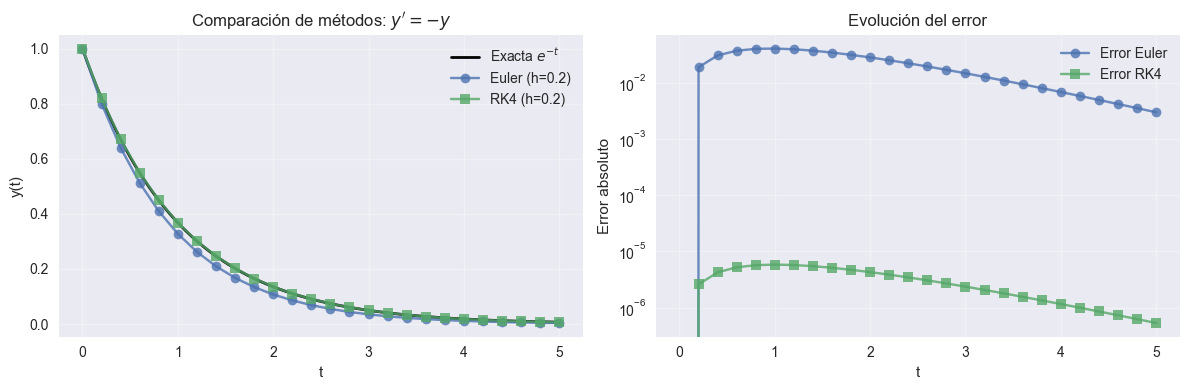

Error final Euler: 2.960054e-03
Error final RK4:   5.308913e-07
Mejora RK4/Euler:  5575.6x


In [7]:
# Ejemplo comparativo: y' = -y, y(0) = 1, solución exacta y(t) = e^(-t)
# Comparamos Euler, RK4 y la solución exacta

def compare_methods_demo():
    # Problema: y' = -y, y(0) = 1
    f_demo = lambda t, y: -y
    t0, y0 = 0.0, 1.0
    t_final = 5.0
    h = 0.2  # Paso relativamente grande para ver diferencias
    n = int((t_final - t0) / h)
    
    # Euler
    t_euler, y_euler = euler(f_demo, t0, y0, h, n)
    
    # RK4
    t_rk4, y_rk4 = rk4(f_demo, t0, y0, h, n)
    
    # Exacta
    t_exact = np.linspace(t0, t_final, 500)
    y_exact = np.exp(-t_exact)
    
    # Gráfica
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Izquierda: Trayectorias
    ax1.plot(t_exact, y_exact, 'k-', lw=2, label='Exacta $e^{-t}$')
    ax1.plot(t_euler, y_euler, 'o-', label=f'Euler (h={h})', alpha=0.8)
    ax1.plot(t_rk4, y_rk4, 's-', label=f'RK4 (h={h})', alpha=0.8)
    ax1.set_xlabel('t')
    ax1.set_ylabel('y(t)')
    ax1.set_title('Comparación de métodos: $y\' = -y$')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Derecha: Errores
    y_exact_at_euler = np.exp(-t_euler)
    y_exact_at_rk4 = np.exp(-t_rk4)
    error_euler = np.abs(y_euler - y_exact_at_euler)
    error_rk4 = np.abs(y_rk4 - y_exact_at_rk4)
    
    ax2.semilogy(t_euler, error_euler, 'o-', label='Error Euler', alpha=0.8)
    ax2.semilogy(t_rk4, error_rk4, 's-', label='Error RK4', alpha=0.8)
    ax2.set_xlabel('t')
    ax2.set_ylabel('Error absoluto')
    ax2.set_title('Evolución del error')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Error final Euler: {error_euler[-1]:.6e}")
    print(f"Error final RK4:   {error_rk4[-1]:.6e}")
    print(f"Mejora RK4/Euler:  {error_euler[-1]/error_rk4[-1]:.1f}x")

compare_methods_demo()

---

## Conclusión del Taller

Este notebook ha cubierto los fundamentos teóricos y prácticos de:

1. **Series de Taylor**: Aproximación polinomial local de funciones.
2. **Diferencias finitas**: Métodos numéricos para estimar derivadas con diferentes órdenes de precisión.
3. **Métodos de integración numérica de EDOs**:
   - **Euler** (orden 1): Simple pero impreciso.
   - **Verlet** (orden 2): Ideal para mecánica conservativa.
   - **RK4** (orden 4): Excelente balance precisión/costo, propósito general.

### Resultados Principales del Taller

✅ **Punto 1**: Series de Taylor aproximan funciones mediante polinomios (respuesta: b).

✅ **Punto 2**: La expansión de Taylor de orden 4 para un polinomio de grado 4 es exacta.

✅ **Punto 3**: Diferencias finitas central tiene error $O(h^2)$, mucho mejor que adelante/atrás $O(h)$.

✅ **Punto 4**: Euler usa $Y_{n+1} = Y_n + h f(X_n, Y_n)$ (respuesta: a).

✅ **Punto 5**: Euler con h=1e-4 aproxima y(1) con error ~6e-5.

✅ **Punto 6**: Verlet reproduce caída libre con error ~3e-6 s en tiempo de impacto; Euler tiene error ~5e-3 s.

✅ **Punto 7**: RK4 usa fórmula $y_{n+1} = y_n + \tfrac{h}{6}(k_1 + 2k_2 + 2k_3 + k_4)$ (respuesta: c).

✅ **Punto 8**: RK4 con N=10 (h=−0.1) integra hacia atrás con error ~2e-6 vs referencia de alta precisión.

### Lecciones Clave

🔑 **No hay un método universal**: La elección depende del problema, precisión requerida y costo computacional.

🔑 **Validación es esencial**: Siempre comparar con soluciones conocidas, verificar convergencia y conservación de cantidades físicas.

🔑 **Orden importa**: Métodos de orden superior permiten pasos mucho mayores para la misma precisión.

**¡Felicitaciones por completar el taller de Física Computacional 1!** 🎉